<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 28px; color: black; font-weight: bold;">
A neural ODE toy model
</div>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import timeit
from torch.distributions import Normal, Independent, kl_divergence, MultivariateNormal
from torchdiffeq import odeint, odeint_adjoint
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
def seed_everything(seed=42):
    """
    Set seed for reproducibility.
    """
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
seed_everything()

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    dtype = torch.cuda.FloatTensor
else:
    device = torch.device('cpu')
    dtype = torch.FloatTensor

print(f"Using {device}")

torch.set_default_dtype(torch.float32)

if device.type == 'cuda':
    print('GPU Name:', torch.cuda.get_device_name(0))
    print('Total GPU Memory:', round(torch.cuda.get_device_properties(0).total_memory/1024**3,1), 'GB')

Using cuda
GPU Name: NVIDIA GeForce RTX 3080
Total GPU Memory: 9.8 GB


<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 28px; color: black; font-weight: bold;">
Data
</div>

<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 16px; color: black; font-weight: bold;">
Ground truth
</div>

In [4]:
class SpiralFlow(nn.Module):
    """
    Defines the gradient flow of the 2D Spiral as a nn.Module to be used in odeint_adjoint from torchdiffeq
    Inputs:
        - t (scalar tensor): time. Here, the flow is time-invariant, so t is not used. However it is required by the ODE solver.
        - x (tensor of shape (2,)): current position in the 2D plane.
        - mu (float): parameter of the spiral.
    Outputs:
        - x_dot (tensor of shape (2,)): time derivative of the position.
    """
    def __init__(self, mu=0.01):
        super(SpiralFlow, self).__init__()
        self.mu = mu

    def forward(self, t, x):
        x1, x2 = x[0], x[1]
        r  = x1**2 + x2**2
        x1_dot = self.mu * x1 - x2 - x1 * r
        x2_dot = x1 + self.mu * x2 - x2 * r
        return torch.stack([x1_dot, x2_dot])
    
spiral_flow = SpiralFlow().to(device)

x = torch.tensor([2., 0.], device=device, requires_grad=True)
t = torch.tensor([10.], device=device)
dx = spiral_flow(t, x)
print(dx)

tensor([-7.9800,  2.0000], device='cuda:0', grad_fn=<StackBackward0>)


Trajectory parameters

In [5]:
# starting point
x0 = torch.tensor([2.0, 0.0], dtype=torch.float, requires_grad=True).to(device)

# number of points in the trajectory
n_steps = 1000

# time span
t_0 = 0.0  # time of the latent prior z0
t_start = 1.0
t_end = 20.0
ts = torch.linspace(t_start, t_end, n_steps).to(device)

In [6]:
# compute the trajectory
gt_trajectory = odeint_adjoint(spiral_flow, x0, ts, rtol=1e-2, atol=1e-2, method='rk4')

# compute gradients along the trajectory
gradients = []
x = x0.detach().to(device)

for t,x in zip(ts, gt_trajectory):
    gradients.append(spiral_flow(t,x).detach().cpu().numpy())
    
gt_gradients = torch.tensor(np.array(gradients)).to(device)

In [7]:
def plot_trajectory_2D(ts, trajectory, gradients, sampled_ts=None, sampled_trajectory=None, sampled_gradients=None, interval=5, scale=5.0, title="2D Trajectory"):
    """
    Plot the trajectory and the vector field.
    Inputs:
        ground truth:
        - ts (tensor of shape (n_steps,)): time points.
        - trajectory (tensor of shape (n_steps, 2)): trajectory points.
        - gradients (tensor of shape (n_steps, 2)): gradients at each trajectory point.
        sampled points (optional):
        - sampled_ts (tensor of shape (n_sampled,)): sampled time points.
        - sampled_trajectory (tensor of shape (n_sampled, 2)): sampled trajectory points.
        - sampled_gradients (tensor of shape (n_sampled, 2)): gradients
        visualization parameters:
        - interval (int): interval for quiver plot.
        - scale (float): scale for quiver plot.
        - title (str): title of the plot.
    Outputs:
        - fig, ax: matplotlib figure and axis.
    """
    fig, ax = plt.subplots(figsize=(6,6))

    X,Y = trajectory[:,0].detach().cpu().numpy(), trajectory[:,1].detach().cpu().numpy()
    U,V = gradients[:,0].detach().cpu().numpy(), gradients[:,1].detach().cpu().numpy()

    if sampled_trajectory is not None and sampled_gradients is not None:
        X_s, Y_s = sampled_trajectory[:,0].detach().cpu().numpy(), sampled_trajectory[:,1].detach().cpu().numpy()
        U_s, V_s = sampled_gradients[:,0].detach().cpu().numpy(), sampled_gradients[:,1].detach().cpu().numpy()
        s = [50.0] * len(X_s)  # Set a fixed size for all points
        ax.scatter(X_s, Y_s, color='b', marker='x', s=s, label='Sampled Trajectory')
        ax.quiver(X_s, Y_s, U_s, V_s, angles='xy', scale_units='xy', scale=scale, color='b', alpha=0.5, label='Sampled Vector Field')
    
    ax.plot(X,Y, label='GT Trajectory', alpha=0.2, marker='.')
    ax.plot(X[0], Y[0], 'go', label='Start', alpha=0.5)
    ax.plot(X[-1], Y[-1], 'ro', label='End', alpha=0.5)
    ax.quiver(X[::interval], Y[::interval], U[::interval], V[::interval], angles='xy', scale_units='xy', scale=scale, alpha=0.2, label='GT Vector Field')
    ax.set_xlabel("X axis")
    ax.set_ylabel("Y axis")
    ax.set_title(title)
    ax.legend()
    ax.grid(True)
    
    return fig, ax

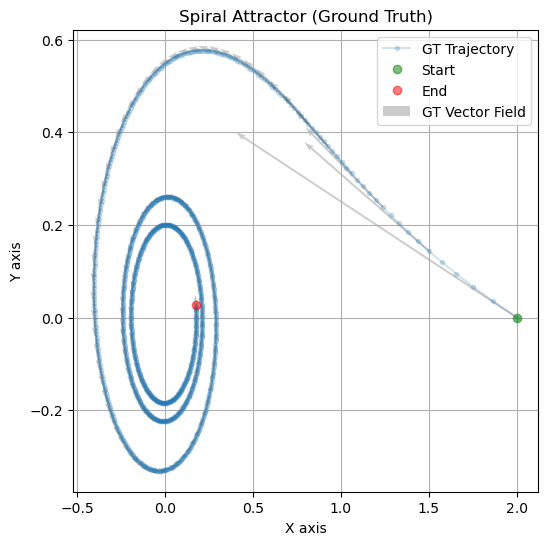

In [8]:
fig, ax = plot_trajectory_2D(ts, gt_trajectory, gt_gradients, title="Spiral Attractor (Ground Truth)")

<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 16px; color: black; font-weight: bold;">
Create data batch by adding noise and sampling random points from the ground truth trajectory
</div>

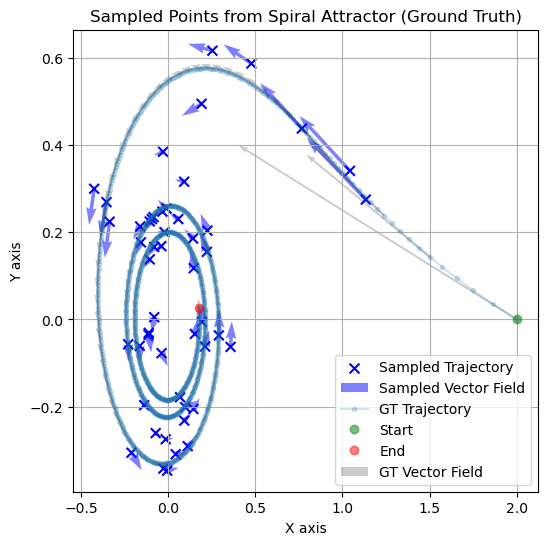

In [30]:
# ratio of points to sample from the entire trajectory
ratio = 0.05
n_points = int(ratio * n_steps)
indices = np.sort(np.random.choice(n_steps, n_points, replace=False))
sampled_ts = ts[indices]
sampled_trajectory = gt_trajectory[indices]
sampled_gradients = gt_gradients[indices]

# add noise to the sampled points
noise_level = 0.05
noise = noise_level * torch.randn_like(sampled_trajectory)
sampled_trajectory = sampled_trajectory + noise

fig, ax = plot_trajectory_2D(ts, gt_trajectory, gt_gradients, sampled_ts, sampled_trajectory, sampled_gradients, title="Sampled Points from Spiral Attractor (Ground Truth)")

In [41]:
# create batch data of noisy samples of ground truth trajectory
batch_size = 16

batch_ts = ts.unsqueeze(0).repeat((batch_size,1))
batch_gt_trajectory = gt_trajectory.unsqueeze(0).repeat((batch_size,1,1))
batch_gt_gradients = gt_gradients.unsqueeze(0).repeat((batch_size,1,1))

# indices to pick : (batch_size, n_points) array of indices
indices = np.sort(np.random.choice(n_steps, (batch_size, n_points), replace=False), axis=1)

# sample data
indices = torch.from_numpy(indices).long().to(ts.device)
batch_sampled_ts = ts[indices]
batch_sampled_trajectory = gt_trajectory[indices]
batch_sampled_gradients = gt_gradients[indices]

# add noise to the sampled points
noise_level = 0.05
noise = noise_level * torch.randn_like(batch_sampled_trajectory)
batch_sampled_trajectory = batch_sampled_trajectory + noise

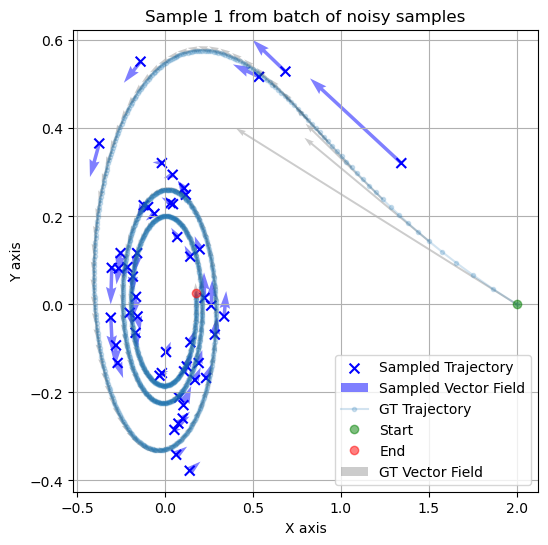

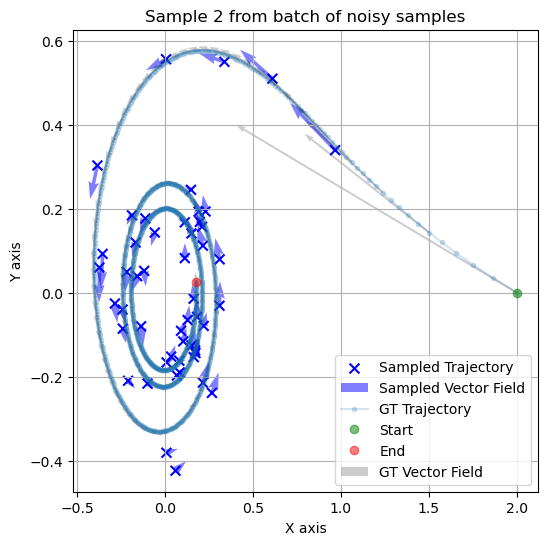

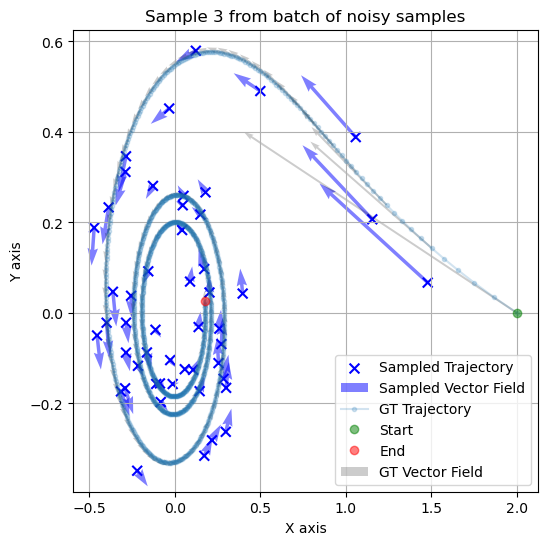

In [42]:
# display some samples
N = 3

for i in range(N):
    fig, ax = plot_trajectory_2D(batch_ts[i], batch_gt_trajectory[i], batch_gt_gradients[i], 
                                 batch_sampled_ts[i], batch_sampled_trajectory[i], batch_sampled_gradients[i], 
                                 title=f"Sample {i+1} from batch of noisy samples")
    plt.show()

<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 28px; color: black; font-weight: bold;">
Model - Step by step pipeline
</div>

from: [ArviX Latent ODEs for Irregularly-Sampled Time Series](https://arxiv.org/abs/1907.03907)

We want to learn the flow dynamics from the batch sampled data

![Alt text](/home/benjamin.deporte/MVA/MVA_Stage/images/Neural_ODE_01.png)

Computing the ELBO:

Data is $x_{t_1}, x_{t_2},...,x_{t_N}$.

Model:
\begin{align}
    z_{t_0} = z_0 &\sim \mathcal{N}(0,1) \\
    z_1, z_2, ..., z_N &= \text{ODESolve}(z_0, f_{\theta}, t_0, ..., t_N) \\
    x_i \vert z_i &\sim \mathcal{N}(\mu_{\theta_x}(z_i), \text{diag}\, \sigma_x(z_i)) \\
    q_\phi(z_0 \vert x_{1:N}) &= \mathcal{N}(\mu_\phi(x_{1:N}), \text{diag} \, \sigma_\phi(x_{1:N})) \\
    [ \mu_\phi, \sigma_\phi ](x_{1:N}) &= \text{RNN} \, (x_{1:N}, t_{1:N})
\end{align}

ELBO:
\begin{align}
    p(x_{1:N}) &= \frac{p(x_{1:N}, z_{1:N})}{p(z_{1:N} \vert x_{1:N})} \\
    \log{p(x_{1:N})} &= \mathbb{E}_{q_{\phi}(z_0 \vert x_{1:N})} \log{\frac{p(x_{1:N}, z_{1:N})}{q_{\phi}(z_0 \vert x_{1:N})}\frac{q_{\phi}(z_0 \vert x_{1:N})}{p(z_{1:N} \vert x_{1:N})}} \\
    &= \mathbb{E}_{q_{\phi}(z_0 \vert x_{1:N})} \log{\frac{p(x_{1:N}, z_{1:N})}{q_{\phi}(z_0 \vert x_{1:N})}} + \mathbb{KL}(q_{\phi}(z_0 \vert x_{1:N}) \vert\vert p(z_{1:N} \vert x_{1:N}) ) \\
    &\geq \mathcal{L}(x_{1:N}, \theta, \phi) = \mathbb{E}_{q_{\phi}(z_0 \vert x_{1:N})} \log{\frac{p(x_{1:N}, z_{1:N})}{q_{\phi}(z_0 \vert x_{1:N})}} \\
    \mathcal{L}(x_{1:N}, \theta, \phi) &= \mathbb{E}_{q_{\phi}(z_0 \vert x_{1:N})} \log{\frac{\prod_{i=1}^{n}p_{\theta_x}(x_i \vert z_i) p(z_0)}{q_{\phi}(z_0 \vert x_{1:N})}} \\
    &= \sum_{i=1}^{n} \mathbb{E}_{q_{\phi}(z_0 \vert x_{1:N})} \log{p_{\theta_x}(x_i \vert z_i)} - \mathbb{KL}(q_{\phi}(z_0 \vert x_{1:N}) \vert\vert p(z_0))
\end{align}

Parameters

In [43]:
Dx = 2  # dimension of the data
Dz = 4  # dimension of the latent space

Data

In [44]:
x = batch_sampled_trajectory
print(f"Data x: {x.shape}")
print(f"\tBatch size: {x.shape[0]}")
print(f"\tNumber of sampled points: {x.shape[1]}")
print(f"\tData dimension: {x.shape[2]} (should be {Dx})")

Data x: torch.Size([16, 50, 2])
	Batch size: 16
	Number of sampled points: 50
	Data dimension: 2 (should be 2)


Prior

In [45]:
# Starting z0 : random variable according to prior p(z0) = N(0, I)

p_theta_z = MultivariateNormal(torch.zeros(Dz).to(device), torch.eye(Dz).to(device))
z0 = p_theta_z.sample((batch_size,))

print(f"Priors z0 : {z0.shape}")

Priors z0 : torch.Size([16, 4])


In [ ]:
# from z1 to zN : Computing the latent variables along the trajectories by the latent ODE

class LatentODEFunc(nn.Module):
    """
    Defines the latent ODE to compute deterministically the latent variables from z0 and the times steps.
    Inputs:
        - Dz (int): dimension of the latent space.
        - hidden_dim (int): dimension of the hidden layers.
    Outputs:
        - z_dot (tensor of shape (batch_size, Dz)): time derivative of the latent variable.
    """
    def __init__(self, Dz, hidden_dim=50):
        super(LatentODEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(Dz, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, Dz)
        )

    def forward(self, t, z):
        # here we assume time invariance, so t is not used
        return self.net(z)

In [47]:
latent_ode_func = LatentODEFunc(Dz).to(device)

z = torch.randn((batch_size, Dz)).to(device)
outputs = latent_ode_func(0, z)
print(f"Latent ODE function input: {z.shape} (should be ({batch_size}, {Dz}))")
print(f"Latent ODE function output: {outputs.shape} (should be ({batch_size}, {Dz}))")

Latent ODE function input: torch.Size([16, 4]) (should be (16, 4))
Latent ODE function output: torch.Size([16, 4]) (should be (16, 4))


In [68]:
print(batch_sampled_ts.shape)

t0s_ = torch.tensor([t_0], device=device).unsqueeze(0).repeat((batch_size,1))
times_ = torch.cat([t0s_, batch_sampled_ts], dim=1)

# run one ODE per batch dimension
for i in range(batch_size):
    times = times_[i]
    z0_ = z0_samples[i]
    z_sample = odeint_adjoint(latent_ode_func, z0_, times, rtol=1e-2, atol=1e-2, method='rk4')
    if i == 0:
        z_samples = z_sample[1:,:].unsqueeze(0)
    else:
        z_samples = torch.cat([z_samples, z_sample[1:,:].unsqueeze(0)], dim=0)
        
print(f"z_samples: {z_samples.shape}")

print(f"\tBatch size: {z_samples.shape[0]} (should be {batch_size})")
print(f"\tNumber of time points: {z_samples.shape[1]} (should be {n_points})")
print(f"\tLatent dimension: {z_samples.shape[2]} (should be {Dz})")

torch.Size([16, 50])
z_samples: torch.Size([16, 50, 4])
	Batch size: 16 (should be 16)
	Number of time points: 50 (should be 50)
	Latent dimension: 4 (should be 4)


Likelihood \ decoder

In [69]:
class Decoder(nn.Module):
    """
    Decoder to map the latent state z to the data space x.
    Inputs:
        - latent_size (int): dimension of the latent space (Dz).
        - output_size (int): dimension of the output data (Dx).
        - hidden_size (int): dimension of the hidden layer.
        - n_layers (int): number of layers in the MLP.
    Outputs:
        - x_recon (tensor of shape (batch_size, seq_len, Dx)): reconstructed data points.
    """
    def __init__(self, latent_size, output_size, hidden_size=32, n_layers=2):
        super(Decoder, self).__init__()
        layers = []
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.Dz = latent_size
        self.Dx = output_size
        input_size = latent_size
        for i in range(n_layers - 1):
            layers.append(nn.Linear(input_size, hidden_size))
            layers.append(nn.Tanh())
            input_size = hidden_size
        layers.append(nn.Linear(hidden_size, output_size * 2))  # output mean and logvar
        self.mlp = nn.Sequential(*layers)
        
    def forward(self, z):
        # z: latent states (batch_size, seq_len, latent_size)
        mu_x = self.mlp(z)[:,:,:self.Dx]  # (batch_size, seq_len, output_size)
        logvar_x = self.mlp(z)[:,:,self.Dx:]  # (batch_size, seq_len, output_size)
        return mu_x, logvar_x
    
    def __repr__(self):
        return f"Decoder(latent_size={self.Dz}, output_size={self.Dx}, hidden_size={self.hidden_size}, n_layers={self.n_layers})"

In [70]:
decoder = Decoder(latent_size=Dz, output_size=Dx, hidden_size=32, n_layers=2).to(device)

mu_x, logvar_x = decoder(z_samples)

print(f"Inputs to Decoder: z_samples {z_samples.shape}")
print(f"Outputs of Decoder: mu_x {mu_x.shape}, logvar_x {logvar_x.shape}")

Inputs to Decoder: z_samples torch.Size([16, 50, 4])
Outputs of Decoder: mu_x torch.Size([16, 50, 2]), logvar_x torch.Size([16, 50, 2])


In [71]:
sigma_x = torch.exp(0.5 * logvar_x).to(device)

# p_theta_x = MultivariateNormal(mu_x, sigma_x)
p_theta_x = Independent(Normal(mu_x, sigma_x),1)
print(f"p_theta_x: {p_theta_x}")

p_theta_x: Independent(Normal(loc: torch.Size([16, 50, 2]), scale: torch.Size([16, 50, 2])), 1)


In [ ]:
# reconstruction loss:
print(f"batch_sampled_trajectory: {batch_sampled_trajectory.shape}")

rec_loss = -p_theta_x.log_prob(batch_sampled_trajectory)
print(f"Reconstruction loss: {rec_loss.shape}")
print(f"\tBatch size: {rec_loss.shape[0]} (should be {batch_size})")
print(f"\tNumber of sampled points: {rec_loss.shape[1]} (should be {n_points})")

batch_sampled_trajectory: torch.Size([16, 50, 2])
Reconstruction loss: torch.Size([16, 50])
	Batch size: 16 (should be 16)
	Number of sampled points: 50 (should be 50)


Posterior

In [74]:
class RNNEncoder(nn.Module):
    """
    RNN Encoder to infer the initial latent state z0 from the observed data.
    Inputs:
        - input_size (int): dimension of the input data (Dx).
        - hidden_size (int): dimension of the hidden state in the RNN.
        - latent_size (int): dimension of the latent space (Dz).
        - n_layers (int): number of layers in the RNN.
    Outputs:
        - z0_mean (tensor of shape (batch_size, Dz)): mean of the inferred initial latent state.
        - z0_logvar (tensor of shape (batch_size, Dz)): log-variance of the inferred initial latent state.
    """
    def __init__(self, input_size, hidden_size, latent_size, n_layers=1):
        super(RNNEncoder, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.Dx = input_size
        self.Dz = latent_size
        # NB : the input size of the RNN is Dx + 1 for the time stamp concatenated to the data point
        self.rnn = nn.LSTM(input_size + 1, hidden_size, n_layers, batch_first=True)
        self.fc_mean = nn.Linear(hidden_size, latent_size)
        self.fc_logvar = nn.Linear(hidden_size, latent_size)
        
    def forward(self, t, x):
        # t: sequence of time stamps (batch_size, seq_len)
        # x: sequence of data points (batch_size, seq_len, input_size)
        times = t.unsqueeze(-1)  # (batch_size, seq_len, 1)
        x_ext = torch.cat([x, times], dim=-1)  # (batch_size, seq_len, input_size + 1)
        _, h_n = self.rnn(x_ext)  # h_n: (n_layers, batch_size, hidden_size)
        h_n = h_n[-1]  # take the last layer's hidden state: (batch_size, hidden_size)
        z0_mean = self.fc_mean(h_n)  # (batch_size, latent_size)
        z0_logvar = self.fc_logvar(h_n)  # (batch_size, latent_size)
        return z0_mean, z0_logvar
    
    def __repr__(self):
        return f"RNNEncoder(input_size={self.Dx} (+1 for time stamps), hidden_size={self.hidden_size}, latent_size={self.Dz}, n_layers={self.n_layers})"

In [75]:
rnn_encoder = RNNEncoder(input_size=Dx, hidden_size=32, latent_size=Dz, n_layers=1).to(device)
z0_mean, z0_logvar = rnn_encoder(batch_sampled_ts, batch_sampled_trajectory)

print(rnn_encoder)
print(f"Inputs to RNN Encoder: batch_sampled_ts {batch_sampled_ts.shape}, batch_sampled_trajectory {batch_sampled_trajectory.shape}")
print(f"outputs of RNN Encoder: z0_mean {z0_mean.shape} z0_logvar {z0_logvar.shape} ")

RNNEncoder(input_size=2 (+1 for time stamps), hidden_size=32, latent_size=4, n_layers=1)
Inputs to RNN Encoder: batch_sampled_ts torch.Size([16, 50]), batch_sampled_trajectory torch.Size([16, 50, 2])
outputs of RNN Encoder: z0_mean torch.Size([1, 16, 4]) z0_logvar torch.Size([1, 16, 4]) 


In [76]:
mu_phi = z0_mean.to(device)
print(mu_phi.shape)
sigma_phi = torch.diag_embed(torch.exp(0.5 * z0_logvar).to(device))
print(sigma_phi.shape)

q_phi = MultivariateNormal(mu_phi, sigma_phi)
print(f"q_phi: {q_phi}")
print(f"\tbatch shape: {q_phi.batch_shape}, event shape: {q_phi.event_shape}")

z0_samples = q_phi.rsample().to(device).squeeze()
print(f"z0_samples: {z0_samples.shape}")
print(f"\tBatch size: {z0_samples.shape[0]}")
print(f"\tDimension: {z0_samples.shape[1]}")

torch.Size([1, 16, 4])
torch.Size([1, 16, 4, 4])
q_phi: MultivariateNormal(loc: torch.Size([1, 16, 4]), covariance_matrix: torch.Size([1, 16, 4, 4]))
	batch shape: torch.Size([1, 16]), event shape: torch.Size([4])
z0_samples: torch.Size([16, 4])
	Batch size: 16
	Dimension: 4


In [77]:
kl_loss = kl_divergence(q_phi, p_theta_z).to(device)
print(f"KL loss: {kl_loss.shape}")

KL loss: torch.Size([1, 16])


Total loss

In [79]:
loss = rec_loss.mean() + kl_loss.mean()
print(f"Total loss: {loss.item()}")

Total loss: 4.481342315673828


In [80]:
loss.backward()